<a href="https://colab.research.google.com/github/craigbosco/public/blob/main/Copy_of_optuna_reps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 15.4 MB/s 
     |████████████████████████████████| 209 kB 84.9 MB/s 
     |████████████████████████████████| 81 kB 9.8 MB/s 
     |████████████████████████████████| 78 kB 7.4 MB/s 
     |████████████████████████████████| 147 kB 68.1 MB/s 
     |████████████████████████████████| 112 kB 68.2 MB/s 
     |████████████████████████████████| 50 kB 6.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=c828a980b88128d06c609bb5cddb78c4a98749252511d0e041eb4704029629cd
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 15.8 MB/s 


In [ ]:
import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import log_loss 
from sklearn.model_selection import KFold, GroupKFold 
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans

import xgboost as xgb

import optuna 
import shap
from tqdm.notebook import tqdm

# rep 1

In [ ]:
def cluster_model():
  km = KMeans(4)
  km.fit(train.loc[:, ['total_trans_amt', 'total_revolving_bal']])
  return km

def preprocess(data):
  x = data.dtypes
  code_cols = x[x=='object'].index.values.tolist()
  for col in code_cols:
    data[f"{col}_code"] = data[col].astype('category').cat.codes
  code_cols = [f"{x}_code" for x in code_cols]

  km = cluster_model()
  data['cluster'] = pd.DataFrame(km.transform(data.loc[:, ['total_trans_amt', 'total_revolving_bal']]), index=data.index).idxmin(axis=1)
  data['cluster_val'] = pd.DataFrame(km.transform(data.loc[:, ['total_trans_amt', 'total_revolving_bal']]), index=data.index).min(axis=1)
  data['ratio'] = data['total_trans_amt'].div(data['total_trans_ct'])
  data['ratio2'] = data['total_amt_chng_q4_q1'].div(data['total_ct_chng_q4_q1'])  
  data.loc[(data['ratio2'].isna()) | (data['ratio2']==np.inf) | (data['ratio2']==-np.inf), 'ratio2'] = -1
  data['ratio3'] = data['total_revolving_bal'].div(data['credit_limit'])
  return data

In [ ]:
project_dir = 'drive/My Drive/cc-churn'
train = pd.read_csv(f"{project_dir}/train.csv")
test = pd.read_csv(f"{project_dir}/test.csv")

train = preprocess(train)
test = preprocess(test)

id_cols = ['id']
feats = ['customer_age', 'total_relationship_count','education_level_code', 'income_category_code',
       'months_inactive_12_mon', 'credit_limit', 'total_revolving_bal',
       'total_amt_chng_q4_q1', 'total_trans_amt', 'total_trans_ct',
       'total_ct_chng_q4_q1', 'avg_utilization_ratio', 'cluster', 'cluster_val', 
       'ratio', 'ratio2', 'ratio3']
target = 'attrition_flag'
model_data = train.loc[:, id_cols+feats+['gender_code',target]].dropna()
model_data.loc[:, feats] = model_data.loc[:, feats].apply(scale)


# sklearn

In [ ]:
folds = 5
kf = KFold(folds)
s = pd.Series()
for train_idx, test_idx in tqdm(kf.split(model_data), total=folds):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]

  # replace with optuna shit 

  model = RandomForestClassifier()
  model.fit(train_data.loc[:, feats], train_data[target])
  
  # continue with regular shit

  _s = pd.DataFrame(model.predict_proba(test_data.loc[:, feats]), index=test_data.index)[1]
  s = s.append(_s)

model_data[f"{target}_rf"] = s

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


  0%|          | 0/5 [00:00<?, ?it/s]

to beat: 

~0.13046831089621383~

~0.11668515825513419~

~0.12149321138752617~

~0.11765137593761603~

~0.11429155537059942~

~0.11487113868751568~

~0.11326290711548949~

~0.1467273248623589~

~0.113856163769962~

~0.12118353528626481~

~0.1143644706502867~

0.11091006608648157

count    7088.000000
mean        0.158812
std         0.286841
min         0.000000
25%         0.000000
50%         0.010000
75%         0.130000
max         1.000000
Name: attrition_flag_rf, dtype: float64

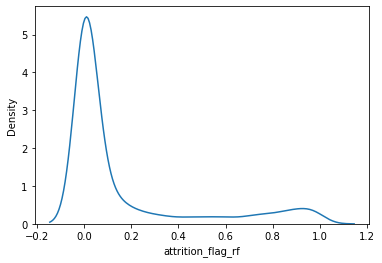

In [ ]:
sns.kdeplot(model_data[f'{target}_rf'])
model_data[f'{target}_rf'].describe()

In [ ]:
loss = log_loss(model_data[target], model_data[f"{target}_rf"])
loss

0.11908862386769811

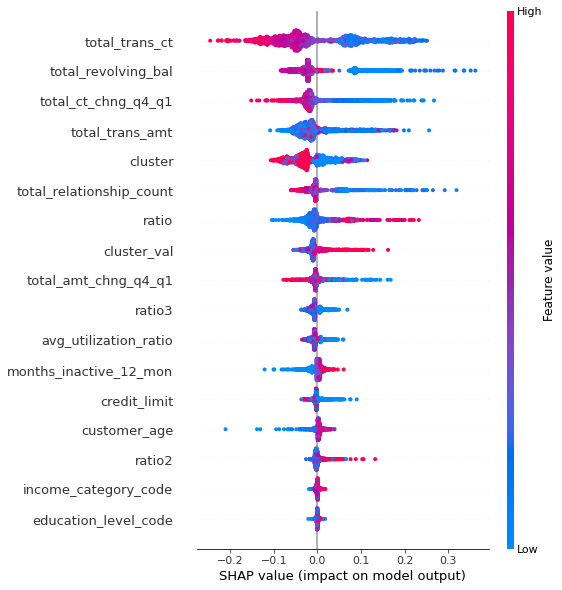

In [ ]:
shap_data = test_data.loc[:,feats]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(shap_data)
shap.summary_plot(shap_values[1], shap_data)

# optuna

In [ ]:
def objective(trial):
  dtrain = xgb.DMatrix(train_data.loc[:, feats], label=train_data[target])
  dvalid = xgb.DMatrix(test_data.loc[:, feats], label=test_data[target])
  param = {
        'silent': 1,
        'objective': 'binary:logistic',
        'learning_rate': trial.suggest_float('learning_rate',0.1,1), 
        'num_leaves': trial.suggest_int('num_leaves', 3, 1024),
        'max_depth':trial.suggest_int('max_depth', 1, 24),
        'n_estimators':trial.suggest_int('n_estimators', 3, 1024),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 15),
        'alpha': trial.suggest_float('alpha', 0, 2),
        'lambda': trial.suggest_float('lambda', 0, 2),
        'gamma': trial.suggest_float('gamma', 0, 100),
    }

  bst = xgb.train(param, dtrain)    
  preds = bst.predict(dvalid)
  loss = log_loss(test_data[target], preds)
  return loss

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

folds = 5
kf = KFold(folds)
s = pd.Series()
df_params = pd.DataFrame()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]

  dtrain = xgb.DMatrix(train_data.loc[:, feats], label=train_data[target])
  dvalid = xgb.DMatrix(test_data.loc[:, feats], label=test_data[target])

  study = optuna.create_study(direction='minimize')
  study.optimize(objective, n_jobs=-1, 
                 n_trials=200, show_progress_bar=True)

  hard_coded = {
      'silent': 1,
      'objective': 'binary:logistic',
  }
  params = {**study.best_params, **hard_coded}

  df_params = (df_params
               .append(pd.DataFrame
                       .from_dict([params]), 
                       ignore_index=True))
  
params = df_params.mean()
params = params.to_dict()  
for col in ['max_depth', 'n_estimators', 'num_leaves']:
  params[col] = int(round(params[col]))

for k in hard_coded.keys():
  params[k] = hard_coded[k]
    
for train_idx, test_idx in tqdm(kf.split(model_data), total=folds):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  dtrain = xgb.DMatrix(train_data.loc[:, feats], label=train_data[target])
  dvalid = xgb.DMatrix(test_data.loc[:, feats], label=test_data[target])

  model = xgb.train(params, dtrain)   

  _s = pd.Series(model.predict(dvalid), index=test_data.index)
  s = s.append(_s)

model_data[f"{target}_gbm"] = s

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/200 [00:00<?, ?it/s]

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/200 [00:00<?, ?it/s]

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/200 [00:00<?, ?it/s]

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/200 [00:00<?, ?it/s]

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/200 [00:00<?, ?it/s]

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


  0%|          | 0/5 [00:00<?, ?it/s]

to beat:  
**0.11326290711548949**  
  

~0.33121786991651453 BROOO??~  
~0.3310271880271977~

~0.3157306919883491~

~0.1013569715127249~ 

0.10056419266771918

In [ ]:
train['edu_income_code'] = (train['education_level_code']
                            .add(1)
                            .astype(str)
                            .add(train['income_category_code']
                                 .add(1)
                                 .astype(str))
                            .astype(int))
_df = pd.get_dummies(train['edu_income_code'])

for col in _df.columns.values:
  train[col] = _df[col]

,11,12,13,14,15,16,21,22,23,24,...,63,64,65,66,71,72,73,74,75,76
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7083,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7084,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7085,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7086,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


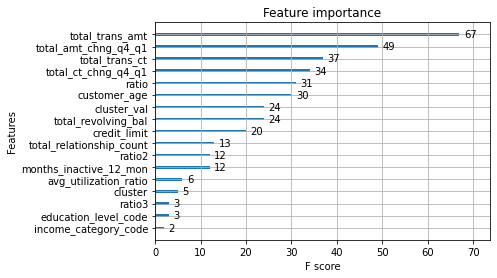

In [ ]:
xgb.plot_importance(model)

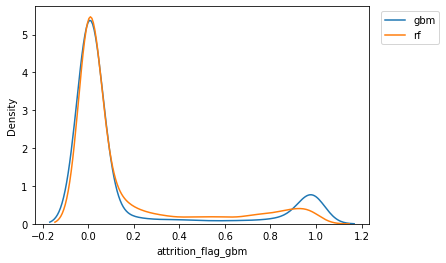

,attrition_flag,attrition_flag_rf,attrition_flag_gbm
count,7088.000000,7088.000000,7088.000000
mean,0.159707,0.158812,0.166232
std,0.366360,0.286841,0.332727
min,0.000000,0.000000,0.000890
25%,0.000000,0.000000,0.002004
50%,0.000000,0.010000,0.005257
75%,0.000000,0.130000,0.049555
max,1.000000,1.000000,0.998140


In [ ]:
sns.kdeplot(model_data[f'{target}_gbm'], label='gbm')
sns.kdeplot(model_data[f'{target}_rf'], label='rf')
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
plt.show()
model_data.loc[:, [target,f'{target}_rf',f'{target}_gbm']].describe()

In [ ]:
model_data['zero'] = 0.5
loss = log_loss(model_data[target], model_data["zero"])
loss

0.6931471805599454

In [ ]:
loss = log_loss(model_data[target], model_data[f"{target}_gbm"])
loss

0.10234960527694048

In [ ]:
model_data.head()

,id,customer_age,total_relationship_count,education_level_code,income_category_code,months_inactive_12_mon,credit_limit,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,...,avg_utilization_ratio,cluster,cluster_val,ratio,ratio2,ratio3,gender_code,attrition_flag,attrition_flag_rf,attrition_flag_gbm
0,8805,-2.415732,-0.527484,0.490648,0.761250,-0.328164,-0.793908,-0.220347,-0.204051,-0.151413,...,1.497509,1.001450,-0.991465,-0.365192,-0.853849,1.498654,0,0,0.00,0.002254
1,4231,-0.538942,1.406048,-1.680208,0.761250,1.651432,-0.617798,0.802444,0.048916,-0.715078,...,1.170884,-1.140456,-0.551264,-0.879003,-0.958327,1.171011,0,0,0.01,0.014332
2,5263,0.086655,-0.527484,1.576076,0.761250,0.661634,-0.780500,-1.434451,-1.166233,-0.722865,...,-0.999354,-1.140456,0.514419,0.278696,-0.405087,-0.999362,0,1,0.84,0.995505
3,2072,-0.288703,-1.816506,1.033362,0.095931,0.661634,1.827441,0.439439,-0.158879,2.695363,...,-0.781604,-0.426487,1.000952,2.903761,-0.392362,-0.781279,1,0,0.01,0.003728
4,7412,0.962490,-0.527484,-0.594780,-0.569389,0.661634,-0.629052,1.283181,-0.000774,-0.783664,...,1.729775,-1.140456,0.397242,-1.131298,0.158847,1.729610,1,0,0.05,0.006427


# rep 2

In [ ]:
from scipy.spatial.distance import euclidean

0       0.122392
1       0.138404
2       0.064582
3       0.083597
4       0.076853
          ...   
9995    0.139068
9996    0.076064
9997    0.100536
9998    0.120913
9999    0.147374
Length: 10000, dtype: float64

In [ ]:
project_dir = 'drive/My Drive/housing-prices'
train = pd.read_csv(f"{project_dir}/train.csv")
test = pd.read_csv(f"{project_dir}/test.csv")

cat_cols = ['priceRange', 'homeType']
for col in cat_cols:
  train[f'{col}_code'] = train[col].astype('category').cat.codes
  try:
    test[f'{col}_code'] = test[col].astype('category').cat.codes
  except:
    pass

train['dtlat'] = 30.27246099389416
train['dtlon'] = -97.7423451933318

train['dtlat2'] = 30.287369860756442 
train['dtlon2'] = -97.72909675966473

test['dtlat'] = 30.27246099389416
test['dtlon'] = -97.7423451933318

test['dtlat2'] = 30.287369860756442 
test['dtlon2'] = -97.72909675966473

train['dist1'] = (((train['latitude'].sub(train['dtlat'])).pow(2)).add(((train['longitude'].sub(train['dtlon'])).pow(2)))).pow(0.5)
test['dist1'] = (((test['latitude'].sub(test['dtlat'])).pow(2)).add(((test['longitude'].sub(test['dtlon'])).pow(2)))).pow(0.5)

train['dist2'] = (((train['latitude'].sub(train['dtlat2'])).pow(2)).add(((train['longitude'].sub(train['dtlon2'])).pow(2)))).pow(0.5)
test['dist2'] = (((test['latitude'].sub(test['dtlat2'])).pow(2)).add(((test['longitude'].sub(test['dtlon2'])).pow(2)))).pow(0.5)

train['ratio1'] = train['lotSizeSqFt'].div(train['numOfBathrooms'])
train['ratio2'] = train['lotSizeSqFt'].div(train['numOfBedrooms'])
train['ratio3'] = train['lotSizeSqFt'].div(train['avgSchoolRating'])

test['ratio1'] = test['lotSizeSqFt'].div(test['numOfBathrooms'])
test['ratio2'] = test['lotSizeSqFt'].div(test['numOfBedrooms'])
test['ratio3'] = test['lotSizeSqFt'].div(test['avgSchoolRating'])

train['remodel'] = 0
x= train['description']
y = train['description'].str.contains('remodel')
train.loc[x[y].index, 'remodel'] = 1

test['remodel'] = 0
x= test['description']
y = test['description'].str.contains('remodel')
test.loc[x[y].index, 'remodel'] = 1

train['furnish'] = 0
x= train['description']
y = train['description'].str.contains('furnish')
train.loc[x[y].index, 'furnish'] = 1

test['furnish'] = 0
x= test['description']
y = test['description'].str.contains('furnish')
test.loc[x[y].index, 'furnish'] = 1

train['pool'] = 0
x= train['description']
y = train['description'].str.contains('pool')
train.loc[x[y].index, 'pool'] = 1

test['pool'] = 0
x= test['description']
y = test['description'].str.contains('pool')
test.loc[x[y].index, 'pool'] = 1

train.shape, test.shape

((10000, 30), (4961, 28))

In [ ]:
test.columns.values

array(['uid', 'city', 'description', 'homeType', 'latitude', 'longitude',
       'garageSpaces', 'hasSpa', 'yearBuilt',
       'numOfPatioAndPorchFeatures', 'lotSizeSqFt', 'avgSchoolRating',
       'MedianStudentsPerTeacher', 'numOfBathrooms', 'numOfBedrooms'],
      dtype=object)

In [ ]:
train.columns.values

array(['uid', 'city', 'description', 'homeType', 'latitude', 'longitude',
       'garageSpaces', 'hasSpa', 'yearBuilt',
       'numOfPatioAndPorchFeatures', 'lotSizeSqFt', 'avgSchoolRating',
       'MedianStudentsPerTeacher', 'numOfBathrooms', 'numOfBedrooms',
       'priceRange', 'priceRange_code', 'homeType_code'], dtype=object)

In [ ]:
x= test['description']
y = test['description'].str.lower().str.contains('price: ')
x[y].values

array(['Great single-family home features 3 bedrooms, 2 bathrooms, 1211 sqft living space. List Price: $150,000!',
       'FOR SALE:: Builder’s Rehab / New Build, Perfect Location \r\n4607 Sara Drive, 78721. Price: $250,000.  4 Bedrooms, 2 Baths \r\nGenerous size lot @ 8525 sq.ft.  Ideal location for duplex \r\nor  build  2 custom Homes.  To add desert to your meal, buy the house\r\nnext door and build 4 houses or 2-duplexes...4609 Sara Drive. \r\nPrice: $260,000. Lot size @ 10,000 sq.ft.  ',
       'PRE-MLS OPEN HOUSE THIS SUNDAY, OCTOBER 7TH 2-5PM\r\n\r\nHighly Rated Eanes ISD | Desirable Senna Hills Neighborhood\r\n\r\n10501 COREOPSIS DRIVE | AUSTIN, TEXAS\r\nLISTING PRICE: $762,000\r\n\r\nFOR CURRENT PRICING & CUTTING EDGE 3D TOUR: www.10501CoreopsisDrive.com\r\n\r\nThis Gorgeous Home Is Located In Desirable Senna Hills Neighborhood & Has An Open Floor Plan Built For Entertaining. Huge Windows Bathe This Home In Natural Light W/ Soaring Ceilings Through-Out, 2 Sided Fireplace You C

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   uid                         10000 non-null  int64  
 1   city                        10000 non-null  object 
 2   description                 10000 non-null  object 
 3   homeType                    10000 non-null  object 
 4   latitude                    10000 non-null  float64
 5   longitude                   10000 non-null  float64
 6   garageSpaces                10000 non-null  int64  
 7   hasSpa                      10000 non-null  bool   
 8   yearBuilt                   10000 non-null  int64  
 9   numOfPatioAndPorchFeatures  10000 non-null  int64  
 10  lotSizeSqFt                 10000 non-null  float64
 11  avgSchoolRating             10000 non-null  float64
 12  MedianStudentsPerTeacher    10000 non-null  int64  
 13  numOfBathrooms              1000

In [ ]:
x = train.dtypes
x[x!='object'].index

Index(['uid', 'latitude', 'longitude', 'garageSpaces', 'hasSpa', 'yearBuilt',
       'numOfPatioAndPorchFeatures', 'lotSizeSqFt', 'avgSchoolRating',
       'MedianStudentsPerTeacher', 'numOfBathrooms', 'numOfBedrooms',
       'priceRange_code', 'homeType_code'],
      dtype='object')

In [ ]:

train['homeType']


Single Family            9427
Condo                     333
Townhouse                 113
Multiple Occupancy         60
Residential                27
Apartment                  19
Mobile / Manufactured      10
MultiFamily                 5
Vacant Land                 4
Other                       2
Name: homeType, dtype: int64

In [ ]:
train.dtypes

uid                             int64
city                           object
description                    object
homeType                       object
latitude                      float64
longitude                     float64
garageSpaces                    int64
hasSpa                           bool
yearBuilt                       int64
numOfPatioAndPorchFeatures      int64
lotSizeSqFt                   float64
avgSchoolRating               float64
MedianStudentsPerTeacher        int64
numOfBathrooms                float64
numOfBedrooms                   int64
priceRange                     object
dtype: object

{1: 0.2356, 2: 0.2301, 3: 0.2275, 4: 0.1819, 0: 0.1249}

0.1249

In [ ]:
_mean_preds = pd.DataFrame.from_dict([(model_data[target].value_counts().div(model_data[target].value_counts().sum())).to_dict()])
_mean_preds.columns = [f"{x}_mean" for x in _mean_preds.columns.values]
col_order = ['0_mean', '1_mean', '2_mean', '3_mean', '4_mean']
for col in col_order:
  model_data[col] = _mean_preds[col].values[0]

mean_loss = log_loss(model_data[target], model_data.loc[:, col_order])
mean_loss

1.5853321469336552

In [ ]:
id_feats = ['uid']
feats = ['latitude', 'longitude', 'garageSpaces', 'dist1', 'dist2',
         'yearBuilt','numOfPatioAndPorchFeatures', 'lotSizeSqFt', 
         'avgSchoolRating', 'MedianStudentsPerTeacher', 'ratio1', 'ratio2',
         'ratio3', 'numOfBathrooms', 'numOfBedrooms', 'homeType_code', 
         'remodel', 'furnish', 'pool']

target = 'priceRange_code' 

model_data = train.loc[train['lotSizeSqFt'].between(1000,35000), id_feats+feats+[target]].dropna()

folds = 5
kf = KFold()
preds = pd.DataFrame()
for train_idx, test_idx in tqdm(kf.split(model_data), total=folds): 
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]

  model = RandomForestClassifier()
  model.fit(train_data.loc[:, feats], train_data[target])
  _df = pd.DataFrame(model.predict_proba(test_data.loc[:, feats]), index=test_data.index)
  preds = preds.append(_df)

pred_cols = []
for col in preds.columns.values:
  model_data[f"{col}_pred"] = preds[col]
  pred_cols.append(f"{col}_pred")

loss = log_loss(model_data[target], model_data.loc[:, pred_cols])
loss


  0%|          | 0/5 [00:00<?, ?it/s]

1.0907333166251734

# journal   
1.0601


# optuna 

In [ ]:
num_class = train[target].unique().shape[0]

In [ ]:
def tune(trial):
  xg_train = xgb.DMatrix(train_data.loc[:, feats], 
                         label=train_data[target])
  
  xg_test = xgb.DMatrix(test_data.loc[:, feats], 
                        label=test_data[target])

  params = {
      'objective':'multi:softprob',
      'verbosity':0, 
      'num_class': num_class, 
      'alpha': trial.suggest_float('alpha', 0,2), 
      'lambda': trial.suggest_float('lambda', 0,2), 
      'eta': trial.suggest_float('eta', 0.1,1),     
      'gamma': trial.suggest_float('gamma', 0, 100),  
  }

  model = xgb.train(params, xg_train)
  preds = model.predict(xg_test)
  loss = log_loss(test_data.loc[:, target], preds)
  return loss

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
folds = 5
kf = KFold()
preds = pd.DataFrame()
df_params = pd.DataFrame()
for train_idx, test_idx in tqdm(kf.split(model_data), total=folds): 
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]

  study = optuna.create_study(direction='minimize')
  study.optimize(tune, n_jobs=-1, n_trials=500, show_progress_bar=True)

  

  _df_params = study.best_params
  df_params = df_params.append(pd.DataFrame.from_dict([_df_params]))


  0%|          | 0/5 [00:00<?, ?it/s]

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/1000 [00:00<?, ?it/s]

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/1000 [00:00<?, ?it/s]

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/1000 [00:00<?, ?it/s]

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/1000 [00:00<?, ?it/s]

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
df_params

,alpha,lambda,eta,gamma
0,1.973665,0.503964,0.698374,0.011948
0,1.917072,1.859467,0.669763,0.003715
0,1.086798,1.964780,0.722798,0.100875
0,1.744337,0.939687,0.649500,0.045898
0,1.565041,1.640389,0.763780,1.864491


In [ ]:

hc = {
      'objective':'multi:softprob',
      'verbosity':0, 
      'num_class': num_class
  }

params = {**df_params.mean().to_dict(), **hc}
int_cols = ['max_delta_step']
# for col in int_cols:
#   params[col] = int(round(params[col],0))
pred_cols = []
preds = pd.DataFrame()
for train_idx, test_idx in tqdm(kf.split(model_data), total=folds): 
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]

  xg_train = xgb.DMatrix(train_data.loc[:, feats], label=train_data[target])
  xg_test = xgb.DMatrix(test_data.loc[:, feats], label=train_data[target])

  model = xgb.train(params,xg_train)
  _df = pd.DataFrame(model.predict(xg_test), index=test_data.index)
  preds = preds.append(_df)

for col in preds.columns.values:
  model_data[f"{col}_pred"] = preds[col]
  pred_cols.append(f"{col}_pred")

xgb.plot_importance(model)
loss = log_loss(model_data[target], model_data.loc[:, pred_cols])
loss


KeyError: ignored

In [ ]:
train['latitude'].mean(), train['longitude'].mean()


(30.291191177177428, -97.77847625427246)

In [ ]:
train['latitude'].median(), train['longitude'].median()

(30.283663749694824, -97.76968002319336)

In [ ]:
x = train['description']
y = train['description'].str.contains('sqft')
x[y].values[3]

'Bank Owned Home in Westlake! ~ Spacious 5 Bedroom, 4.5 Bath Home in Prestigious Rockcliff Estates ~ 3,593 sqft ~ Wood Floors Throughout Downstairs ~ 3 Car Garage ~ Cul-De-Sac ~ View of Lake Austin from Upper Level Deck ~ Sparkling Pool ~ Eanes ISD!'

In [ ]:
train['priceRange'].value_counts()

250000-350000    2356
350000-450000    2301
450000-650000    2275
650000+          1819
0-250000         1249
Name: priceRange, dtype: int64

count     8936.000000
mean      8958.408863
std       3599.626966
min        113.000000
25%       6534.000000
50%       8102.000000
75%      10454.000000
max      24829.200000
Name: lotSizeSqFt, dtype: float64

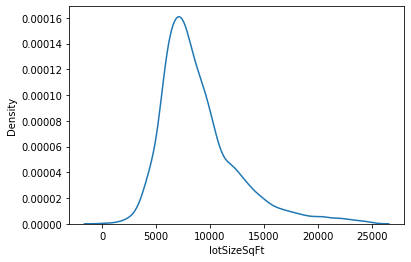

In [ ]:
sns.kdeplot(train.loc[(train['homeType']=='Single Family') & (train['lotSizeSqFt']<25000), 'lotSizeSqFt'])
train.loc[(train['homeType']=='Single Family') & (train['lotSizeSqFt']<25000), 'lotSizeSqFt'].describe()

In [ ]:
thresh = 35000
train.loc[train['lotSizeSqFt']>thresh, target[:-5]].value_counts().div(train.loc[train['lotSizeSqFt']>thresh, target[:-5]].value_counts().sum())

650000+          0.681704
450000-650000    0.167920
350000-450000    0.075188
250000-350000    0.040100
0-250000         0.035088
Name: priceRange, dtype: float64

In [ ]:
thresh = 1000
train.loc[train['lotSizeSqFt']<thresh, target[:-5]].value_counts().div(train.loc[train['lotSizeSqFt']<thresh, target[:-5]].value_counts().sum())

0-250000         0.538462
250000-350000    0.269231
350000-450000    0.115385
450000-650000    0.038462
650000+          0.038462
Name: priceRange, dtype: float64

In [ ]:
x = train['description']
y = train['description'].str.contains('sq')
x[y].values[3]

'5810 N Hampton Dr, Austin, TX 78723 is a single family home that contains 2,000 sq ft and was built in 1964. It contains 4 bedrooms and 2 bathrooms. \r\n \r\n'

In [ ]:
train[target[:-5]].value_counts()

250000-350000    2356
350000-450000    2301
450000-650000    2275
650000+          1819
0-250000         1249
Name: priceRange, dtype: int64

count     9304.000000
mean      8509.542412
std       3224.235318
min        100.000000
25%       6367.000000
50%       7884.000000
75%      10062.000000
max      19602.000000
Name: lotSizeSqFt, dtype: float64

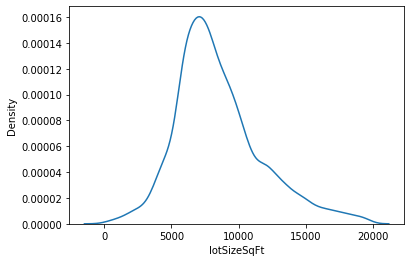

In [ ]:
sns.kdeplot(model_data['lotSizeSqFt'])
model_data['lotSizeSqFt'].describe()

In [ ]:
pred_cols

['0-250000', '250000-350000', '350000-450000', '450000-650000', '650000+']

In [ ]:
test[target] = 0
dtrain = xgb.DMatrix(train.loc[:,feats], label=train[target])
dtest = xgb.DMatrix(test.loc[:,feats], label=test[target])
model = xgb.train(params, dtrain)
preds = model.predict(dtest)

pred_cols = train.loc[:, target[:-5]].sort_values().unique().tolist()
_preds = pd.DataFrame(preds, columns=pred_cols)
for col in pred_cols:
  test[col] = _preds[col]

# test.loc[test['lotSizeSqFt']>35000, pred_cols] = 0
# test.loc[test['lotSizeSqFt']>35000, '650000+'] = 1
# test.loc[test['lotSizeSqFt']<1000, pred_cols] = 0
# test.loc[test['lotSizeSqFt']<1000, '0-250000'] = 1
test.loc[:, id_feats+pred_cols].to_csv(f'{project_dir}/fuck8.csv',index=False)
test.loc[:, id_feats+pred_cols].sample(10)

In [ ]:
test.loc[test['lotSizeSqFt']<1000]

,uid,city,description,homeType,latitude,longitude,garageSpaces,hasSpa,yearBuilt,numOfPatioAndPorchFeatures,...,ratio1,ratio2,priceRange_code,0-250000,250000-350000,350000-450000,450000-650000,650000+,4_pred,0_pred
854,3666,austin,"8900 Trone Cir APT A, Austin, TX 78758 is a co...",Condo,30.362768,-97.710762,2,False,1972,1,...,1.0,196.0,0,0.673562,0.199178,0.105701,0.016995,0.004564,NaN,1.0
937,10598,austin,"407 Post Road Dr, Austin, TX 78704 is a single...",Single Family,30.227434,-97.766029,1,False,2018,3,...,1.0,145.0,0,0.017013,0.084854,0.247554,0.476950,0.173629,NaN,1.0
1067,9206,austin,Huge 1/1 right off the drag. Giant living room...,Condo,30.293509,-97.742760,0,False,1981,0,...,1.0,435.0,0,0.769762,0.060527,0.130243,0.019468,0.020000,NaN,1.0
1943,9573,austin,Possibilities and investment opportunity aboun...,Condo,30.292341,-97.714188,1,True,2019,2,...,0.5,553.0,0,0.077772,0.094743,0.416961,0.375858,0.034665,NaN,1.0
2083,2168,austin,"6907 Old Post Loop, Austin, TX 78744 is a town...",Townhouse,30.178223,-97.754173,3,False,1979,0,...,1.0,304.5,0,0.883604,0.101927,0.010000,0.003604,0.000865,NaN,1.0
2271,9242,austin,MOTIVATED SELLER! Amazing opportunity! Fully...,Condo,30.290279,-97.745552,1,False,1982,0,...,1.0,420.0,0,0.386885,0.180298,0.297754,0.089342,0.045722,NaN,1.0
2901,2157,austin,"Really cute, two-story town home with lots of ...",Condo,30.177485,-97.753250,2,False,1975,1,...,1.0,302.5,0,0.687582,0.292880,0.015235,0.003000,0.001303,NaN,1.0
3647,9208,austin,Amazing location right in Austin. This 1BR 1BA...,Condo,30.275389,-97.754883,0,False,1972,0,...,1.0,967.0,0,0.637253,0.085465,0.152817,0.081415,0.043049,NaN,1.0
3724,9214,austin,Spacious cute 1-1 only 2 blocks to UT! These u...,Condo,30.287333,-97.743378,0,False,1981,0,...,1.0,701.0,0,0.751736,0.064601,0.127194,0.036938,0.019531,NaN,1.0
4562,9238,austin,Spacious 2 Bed/2 Bath loft-style condo in West...,Condo,30.284908,-97.746902,0,False,1982,0,...,1.0,317.5,0,0.398469,0.155755,0.306669,0.092017,0.047091,NaN,1.0


# optuna journal 

~0.9513158679368906~  
0.9478589033228345


# rep 3

In [ ]:
project_dir = 'drive/My Drive/rain-pred'
os.listdir(project_dir)

['sample_submission.csv', 'test.csv', 'train.csv']

In [ ]:
def preprocess(df):
  df['date'] = pd.to_datetime(df['date'])
  df['year'] = df['date'].dt.year
  df['month'] = df['date'].dt.month
  df['day'] = df['date'].dt.day
  df['weekofyear'] = df['date'].dt.weekofyear
  cols = ['evaporation','sunshine', 'cloud9am', 'cloud3pm',
          'wind_gust_speed','wind_speed3pm', 'humidity9am', 
          'humidity3pm', 'pressure9am', 'pressure3pm',
          'rain_today', 'temp9am', 'temp3pm', 'wind_speed9am', 
          'rainfall', 'min_temp', 'max_temp']  
  for col in cols: 
    df[col] = df[col].fillna(-1).astype(int)

  cols = ['location', 'wind_gust_dir','wind_dir9am', 'wind_dir3pm']
  for col in cols:
    df[f"{col}_code"] = df[col].astype('category').cat.codes
  return df

In [ ]:
train = pd.read_csv(f"{project_dir}/train.csv")
test = pd.read_csv(f"{project_dir}/test.csv")

train = preprocess(train)
test = preprocess(test)
train.shape, test.shape

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


((34191, 32), (14653, 31))

In [ ]:
train.columns.values

array(['id', 'date', 'location', 'min_temp', 'max_temp', 'rainfall',
       'evaporation', 'sunshine', 'wind_gust_dir', 'wind_gust_speed',
       'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm',
       'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm',
       'cloud9am', 'cloud3pm', 'temp9am', 'temp3pm', 'rain_today',
       'rain_tomorrow', 'year', 'month', 'day', 'weekofyear',
       'wind_gust_dir_code', 'wind_dir9am_code', 'wind_dir3pm_code'],
      dtype=object)

In [ ]:
train.head()

,id,date,location,min_temp,max_temp,rainfall,evaporation,sunshine,wind_gust_dir,wind_gust_speed,...,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,rain_today,rain_tomorrow
0,6364,2010-11-11,BadgerysCreek,16.2,28.9,11.4,NaN,NaN,SW,37.0,...,78.0,52.0,1017.2,1011.7,NaN,NaN,20.3,27.9,1.0,0
1,7985,2011-03-09,Sale,14.6,28.3,0.0,NaN,NaN,SSE,35.0,...,81.0,65.0,1012.9,1010.4,7.0,7.0,19.0,24.4,0.0,1
2,5021,2014-06-06,Nhil,2.6,16.3,0.0,NaN,NaN,S,31.0,...,93.0,61.0,1033.1,1031.0,NaN,NaN,5.9,14.6,0.0,0
3,28546,2017-06-07,Townsville,14.0,25.9,0.0,NaN,NaN,WNW,35.0,...,66.0,37.0,1020.4,1016.9,NaN,NaN,20.9,24.7,0.0,0
4,42222,2016-12-13,Uluru,16.7,41.7,0.0,NaN,NaN,SW,61.0,...,17.0,7.0,1006.1,1002.6,NaN,NaN,33.2,41.1,0.0,0


In [ ]:
train.columns.values

array(['id', 'date', 'location', 'min_temp', 'max_temp', 'rainfall',
       'evaporation', 'sunshine', 'wind_gust_dir', 'wind_gust_speed',
       'wind_dir9am', 'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm',
       'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm',
       'cloud9am', 'cloud3pm', 'temp9am', 'temp3pm', 'rain_today',
       'rain_tomorrow', 'year', 'month', 'day', 'weekofyear',
       'wind_gust_dir_code', 'wind_dir9am_code', 'wind_dir3pm_code'],
      dtype=object)

In [ ]:
x = train.dtypes
x[x!='object']

id                             int64
date                  datetime64[ns]
min_temp                     float64
max_temp                     float64
rainfall                     float64
evaporation                  float64
sunshine                     float64
wind_gust_speed              float64
wind_speed9am                float64
wind_speed3pm                float64
humidity9am                  float64
humidity3pm                  float64
pressure9am                  float64
pressure3pm                  float64
cloud9am                     float64
cloud3pm                     float64
temp9am                      float64
temp3pm                      float64
rain_today                   float64
rain_tomorrow                  int64
year                           int64
month                          int64
day                            int64
weekofyear                     int64
wind_gust_dir_code              int8
wind_dir9am_code                int8
wind_dir3pm_code                int8
d

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34191 entries, 0 to 34190
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  34191 non-null  int64         
 1   date                34191 non-null  datetime64[ns]
 2   location            34191 non-null  object        
 3   min_temp            34191 non-null  int64         
 4   max_temp            34191 non-null  int64         
 5   rainfall            34191 non-null  int64         
 6   evaporation         34191 non-null  int64         
 7   sunshine            34191 non-null  int64         
 8   wind_gust_dir       31906 non-null  object        
 9   wind_gust_speed     34191 non-null  int64         
 10  wind_dir9am         31759 non-null  object        
 11  wind_dir3pm         33250 non-null  object        
 12  wind_speed9am       34191 non-null  int64         
 13  wind_speed3pm       34191 non-null  int64     

In [ ]:
[]

In [ ]:
ids = ['id', 'date']
feats = ['min_temp', 'max_temp', 'rainfall','wind_gust_speed',
         'wind_speed9am', 'wind_speed3pm', 'humidity9am', 
         'humidity3pm', 'pressure9am', 'pressure3pm',
         'cloud9am', 'cloud3pm', 'temp9am', 'temp3pm', 
         'evaporation','wind_gust_dir_code', 
         'wind_dir9am_code', 'wind_dir3pm_code', 
         'sunshine','rain_today','year', 'month', 'day', 
         'weekofyear']
target = 'rain_tomorrow'

model_data = train.loc[:, ids+feats+[target]].dropna()
model_data.shape

(34191, 27)

In [ ]:
from tqdm.notebook import tqdm 

In [ ]:


folds = 5
kf = KFold (folds)

s = pd.Series()
for train_idx, test_idx in tqdm(kf.split(model_data)):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  xgb_train = xgb.DMatrix(train_data.loc[:, feats], train_data[target])
  xgb_test = xgb.DMatrix(test_data.loc[:, feats], test_data[target])

  p = {
      'objective': 'binary:logistic', 
       'scale_pos_weight': 5
  }

  model = xgb.train(p, xgb_train)
  _s = model.predict(xgb_test)
  s = s.append(pd.Series(_s, index=test_data.index))

model_data[f"{target}_naive"] = s

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


0it [00:00, ?it/s]

In [ ]:
test_data[target].shape

(6838,)

In [ ]:
_s.shape

(6838,)

In [ ]:
log_loss(test_data[target], _s)

0.5093785540238088

In [ ]:
def tune(trial):
  p = {
      'objective':'binary:logistic',
      'scale_pos_weight': trial.suggest_int('scale_pos_weight',1,10),
      'alpha': trial.suggest_float('alpha',0,1),
      'lambda': trial.suggest_float('lambda',0,1),
      'eta': trial.suggest_float('eta',0.1,1),
      'gamma': trial.suggest_float('gamma',0,10)
  }

  model = xgb.train(p, xgb_train)
  _s = model.predict(xgb_test)
  loss = log_loss(test_data[target], _s)
  return loss 

In [ ]:
folds = 5
kf = KFold (folds)

df_params = pd.DataFrame()
for train_idx, test_idx in tqdm(kf.split(model_data), total=folds):
  _df_params = pd.DataFrame()
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  xgb_train = xgb.DMatrix(train_data.loc[:, feats], train_data[target])
  xgb_test = xgb.DMatrix(test_data.loc[:, feats], test_data[target])

  study = optuna.create_study(direction='minimize')
  study.optimize(tune, n_trials=20)
  _df_params = pd.DataFrame([study.best_params])
  df_params = df_params.append(_df_params)


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2022-10-14 03:42:55,259] A new study created in memory with name: no-name-94e5ff4c-31b0-4181-8acd-b8bffa08120c
[I 2022-10-14 03:42:55,527] Trial 0 finished with value: 0.43574334747271154 and parameters: {'scale_pos_weight': 3, 'alpha': 0.7849570471324865, 'lambda': 0.37520286711083994, 'eta': 0.2213777805718143, 'gamma': 9.904195269958503}. Best is trial 0 with value: 0.43574334747271154.
[I 2022-10-14 03:42:55,774] Trial 1 finished with value: 0.36629670000896414 and parameters: {'scale_pos_weight': 1, 'alpha': 0.34559240768622257, 'lambda': 0.7693237819228991, 'eta': 0.8644360853420466, 'gamma': 9.825864093262902}. Best is trial 1 with value: 0.36629670000896414.
[I 2022-10-14 03:42:56,022] Trial 2 finished with value: 0.4766551434322658 and parameters: {'scale_pos_weight': 3, 'alpha': 0.8439395334143728, 'lambda': 0.6495598666028493, 'eta': 0.12402064839963778, 'gamma': 8.479851550806131}. Best is trial 1 with value: 0.36629670000896414.
[I 2022-10-14 03:42:56,623] Trial 3 finis

In [ ]:
df_params

,scale_pos_weight,alpha,lambda,eta,gamma
0,1,0.252722,0.524602,0.552758,9.914862
0,1,0.245697,0.528895,0.383056,0.276561
0,1,0.010409,0.566700,0.401074,0.179528
0,1,0.407338,0.581988,0.399065,7.998751
0,1,0.091472,0.220376,0.302936,0.725745


{'scale_pos_weight': 1.0,
 'alpha': 0.2015274429533372,
 'lambda': 0.4845125227139988,
 'eta': 0.4077779119635741,
 'gamma': 3.8190893490506426}

In [ ]:
s = pd.Series()
for train_idx, test_idx in tqdm(kf.split(model_data)):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  xgb_train = xgb.DMatrix(train_data.loc[:, feats], train_data[target])
  xgb_test = xgb.DMatrix(test_data.loc[:, feats], test_data[target])

  p = {
      'objective': 'binary:logistic', 
       'scale_pos_weight': 5
  }
  params = {**p,**df_params.mean().to_dict()}

  model = xgb.train(params, xgb_train)
  _s = model.predict(xgb_test)
  s = s.append(pd.Series(_s, index=test_data.index))

model_data[f"{target}_fuck"] = s

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


0it [00:00, ?it/s]

In [ ]:
log_loss(model_data[target], model_data[f"{target}_fuck"])

0.3571071863175637

In [ ]:
test[target] = 0
xgb_train = xgb.DMatrix(train.loc[:, feats], train[target])
xgb_test = xgb.DMatrix(test.loc[:, feats], test[target])
model = xgb.train(params, xgb_train)
test[target] = model.predict(xgb_test)

In [ ]:
test.loc[:, ['id', target]].to_csv('yo.csv', index=False)

# rep 4

In [ ]:
def preprocess(df):
  cat_feats = ['neighbourhood_group', 'neighbourhood', 'room_type']
  for col in cat_feats:
    df[f"{col}_code"] = df[col].astype('category').cat.codes
  return df

In [ ]:
project_dir = 'drive/My Drive/airbnb-data'
os.listdir(project_dir)

['sample_submission.csv', 'test.csv', 'train.csv']

In [ ]:
train = pd.read_csv(f"{project_dir}/train.csv")
test = pd.read_csv(f"{project_dir}/test.csv")

train = preprocess(train)
test = preprocess(test)

In [ ]:

train.shape, test.shape

((34226, 19), (14669, 18))

In [ ]:
train.columns.values

array(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'neighbourhood_group_code',
       'neighbourhood_code', 'room_type_code'], dtype=object)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34226 entries, 0 to 34225
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              34226 non-null  int64  
 1   name                            34217 non-null  object 
 2   host_id                         34226 non-null  int64  
 3   host_name                       34212 non-null  object 
 4   neighbourhood_group             34226 non-null  object 
 5   neighbourhood                   34226 non-null  object 
 6   latitude                        34226 non-null  float64
 7   longitude                       34226 non-null  float64
 8   room_type                       34226 non-null  object 
 9   price                           34226 non-null  int64  
 10  minimum_nights                  34226 non-null  int64  
 11  number_of_reviews               34226 non-null  int64  
 12  last_review                     

In [ ]:
x = train.dtypes
feats = [x for x in x[x!='object'].index.values if x not in ['id', 'host_id', 'price']]
target = 'price'

model_data = train.loc[:, feats+[target]].dropna()

folds = 5
kf = KFold(5)

s = pd.Series()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]

  xgb_train = xgb.DMatrix(train_data.loc[:, feats], train_data[target])
  xgb_test = xgb.DMatrix(test_data.loc[:, feats], test_data[target])

  p = {
      'objective':'reg:squarederror'
  }

  model = xgb.train(p, xgb_train)
  _s = pd.Series(model.predict(xgb_test), index=test_data.index)

  s = s.append(_s)

model_data[f"{target}_base"] = s

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [ ]:

from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

In [ ]:
r2 = pearsonr(model_data[target], model_data[f"{target}_base"])[0]**2
rmse = mean_squared_error(model_data[target], model_data[f"{target}_base"])**0.5
r2, rmse

(0.12572598589360193, 187.13069564888144)

In [ ]:
def tune(trial):
  p = {
      'objective':'reg:squarederror',
       'alpha': trial.suggest_float('alpha',0,2),
       'gamma': trial.suggest_float('gamma',0,10),
       'eta': trial.suggest_float('eta',0,1),
       'lambda':trial.suggest_float('lambda',0,2)
  }
  model = xgb.train(p, xgb_train)
  _s = pd.Series(model.predict(xgb_test), index=test_data.index)
  

  rmse = mean_squared_error(test_data[target], _s)**0.5
  return rmse
  


In [ ]:
folds = 5
kf = KFold(5)

s = pd.Series()
df_params = pd.DataFrame()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]

  xgb_train = xgb.DMatrix(train_data.loc[:, feats], train_data[target])
  xgb_test = xgb.DMatrix(test_data.loc[:, feats], test_data[target])
  
  study = optuna.create_study(direction='minimize')
  study.optimize(tune,n_trials=10)

  _df = pd.DataFrame.from_dict([study.best_params])
  df_params = df_params.append(_df, ignore_index=True)

_params = df_params.mean().to_dict()

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[I 2022-10-26 03:54:15,431] A new study created in memory with name: no-name-5b847654-fd03-467d-a439-532ae42d8f1a
[I 2022-10-26 03:54:16,173] Trial 0 finished with value: 190.18943960580134 and parameters: {'alpha': 0.48194508720220064, 'gamma': 4.099948432891956, 'eta': 0.4790273809926435, 'lambda': 0.4080401010450059}. Best is trial 0 with value: 190.18943960580134.
[I 2022-10-26 03:54:17,249] Trial 1 finished with value: 173.04523938739587 and parameters: {'alpha': 1.8551761949828658, 'gamma': 7.269916136684538, 'eta': 0.17267948548362577, 'lambda': 1.5169168522984002}. Best is trial 1 with value: 173.04523938739587.
[I 2022-10-26 03:54:17,381] Trial 2 finished with value: 184.50174116995788 and parameters: {'alpha': 0.5831625260716737, 'gamma': 5.595341225557549, 'eta': 0.08249955639297157, 'lambda': 0.5435351791954186}. Best is trial 1 w

In [ ]:
_params

{'alpha': 0.7839335453278096,
 'gamma': 5.76622635692765,
 'eta': 0.37762667776349507,
 'lambda': 1.6252865411930546}

In [ ]:
s = pd.Series()
df_params = pd.DataFrame()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]

  xgb_train = xgb.DMatrix(train_data.loc[:, feats], train_data[target])
  xgb_test = xgb.DMatrix(test_data.loc[:, feats], test_data[target])

  p = {
      'objective':'reg:squarederror'

  }
  p = {**p, **_params}
  
  model = xgb.train(p, xgb_train)
  _s = pd.Series(model.predict(xgb_test), index=test_data.index)

  s = s.append(_s)

model_data[f"{target}_opt"] = s


The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [ ]:
r2 = pearsonr(model_data[target], model_data[f"{target}_opt"])[0]**2
rmse = mean_squared_error(model_data[target], model_data[f"{target}_opt"])**0.5
r2, rmse

(0.13605326518522487, 185.17699127561042)

In [ ]:
test[target] = train[target].mean()
xgb_train = xgb.DMatrix(model_data.loc[:, feats], model_data[target])
xgb_test = xgb.DMatrix(test.loc[:, feats], test[target])

p = {
    'objective':'reg:squarederror'

}
p = {**p, **_params}

model = xgb.train(p, xgb_train)
s = pd.Series(model.predict(xgb_test), index=test.index)

test[target] = s


In [ ]:
test.loc[:, ['id', target]].to_csv('yo.csv', index=False)

(0.12572598589360193, 187.13069564888144)

(0.13605326518522487, 185.17699127561042)

# rep 5

In [ ]:
project_dir = "drive/My Drive/animal-shelter"
os.listdir(project_dir)

['test.csv', 'sample_submission.csv', 'train.csv']

In [ ]:
def preprocess(df):
  df['date_of_birth'] = pd.to_datetime(df['date_of_birth'])
  df['datetime'] = pd.to_datetime(df['datetime'])

  df['age'] = df['datetime'].sub(df['date_of_birth'])
  df['age'] = df['age'].dt.days
  cat_cols = ['sex', 'spay_neuter', 'outcome_type', 'color', 'animal_type']
  for col in cat_cols:
    df[f"{col}_code"] = df[col].astype('category').cat.codes
  return df

In [ ]:
train = pd.read_csv(f"{project_dir}/train.csv")
test = pd.read_csv(f"{project_dir}/test.csv")
test['outcome_type'] = -1
train = preprocess(train)
test = preprocess(test)


In [ ]:
train.shape, test.shape

((54408, 17), (23317, 17))

In [ ]:
train.columns.values

array(['id', 'age_upon_outcome', 'animal_type', 'breed', 'color',
       'date_of_birth', 'datetime', 'name', 'outcome_type', 'sex',
       'spay_neuter', 'age', 'sex_code', 'spay_neuter_code',
       'outcome_type_code', 'color_code', 'animal_type_code'],
      dtype=object)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54408 entries, 0 to 54407
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 54408 non-null  int64         
 1   age_upon_outcome   54404 non-null  object        
 2   animal_type        54408 non-null  object        
 3   breed              54408 non-null  object        
 4   color              54408 non-null  object        
 5   date_of_birth      54408 non-null  datetime64[ns]
 6   datetime           54408 non-null  datetime64[ns]
 7   name               37975 non-null  object        
 8   outcome_type       54408 non-null  object        
 9   sex                54408 non-null  object        
 10  spay_neuter        54408 non-null  object        
 11  age                54408 non-null  int64         
 12  sex_code           54408 non-null  int8          
 13  spay_neuter_code   54408 non-null  int8          
 14  outcom

In [ ]:
code2type = train.loc[:, ['outcome_type', 'outcome_type_code']].drop_duplicates()
code2type

,outcome_type,outcome_type_code
0,adoption,0
1,no outcome,1
2,transfer,2


In [ ]:
x = train.dtypes
feats = ['age', 'sex_code','spay_neuter_code', 'color_code','animal_type_code']
target = 'outcome_type_code'

In [ ]:
model_data = train.loc[:, feats+[target]].dropna()
folds = 5
kf = KFold(folds)
preds = pd.DataFrame()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]

  xg_train = xgb.DMatrix(train_data.loc[:, feats], train_data[target])
  xg_test = xgb.DMatrix(test_data.loc[:, feats], test_data[target])

  p = {
      'objective':'multi:softprob',
      'num_class':3

  }
  model = xgb.train(p, xg_train)
  _df = pd.DataFrame(model.predict(xg_test), index=test_data.index)
  preds = preds.append(_df)


In [ ]:
model_data = pd.concat([model_data,preds], axis=1)
model_data.head()

,age,sex_code,spay_neuter_code,color_code,animal_type_code,outcome_type_code,0,1,2
0,837,1,0,54,1,0,0.608597,0.068147,0.323256
1,366,2,2,104,4,1,0.024742,0.929307,0.045951
2,63,0,0,104,2,2,0.930543,0.026525,0.042932
3,738,0,0,135,1,2,0.505283,0.070440,0.424278
4,555,0,0,433,2,2,0.790991,0.050289,0.158719


In [ ]:
log_loss(model_data[target], model_data.loc[:, range(3)])

0.5527091334540237

In [ ]:
def tune(trial):
  p = {
      'objective':'multi:softprob',
      'num_class':3,
       'alpha': trial.suggest_float('alpha',0,2),
       'eta': trial.suggest_float('eta',0,2),
       'gamma': trial.suggest_float('gamma',0,10),
       'lambda': trial.suggest_float('lambda',0,2),
  }
  model = xgb.train(p, xg_train)
  _df = pd.DataFrame(model.predict(xg_test), index=test_data.index)
  logloss = log_loss(test_data[target], _df)
  return logloss


In [ ]:
df_params = pd.DataFrame()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]

  xg_train = xgb.DMatrix(train_data.loc[:, feats], train_data[target])
  xg_test = xgb.DMatrix(test_data.loc[:, feats], test_data[target])
  study = optuna.create_study(direction='minimize')
  study.optimize(tune, n_trials=10)
  _df = pd.DataFrame().from_dict([study.best_params])
  df_params = df_params.append(_df)
  

[I 2022-10-27 03:17:08,796] A new study created in memory with name: no-name-993e3eeb-1f04-4d8d-88c9-bf283979d603
[I 2022-10-27 03:17:09,258] Trial 0 finished with value: 0.52134653272301 and parameters: {'alpha': 0.774578311806843, 'eta': 0.711437014960896, 'gamma': 0.817585344007602, 'lambda': 1.1537861836749437}. Best is trial 0 with value: 0.52134653272301.
[I 2022-10-27 03:17:09,643] Trial 1 finished with value: 0.536688238430951 and parameters: {'alpha': 1.4021913349606612, 'eta': 0.6177020517243044, 'gamma': 9.650935720225092, 'lambda': 0.6334446289665581}. Best is trial 0 with value: 0.52134653272301.
[I 2022-10-27 03:17:09,986] Trial 2 finished with value: 0.5260356715137467 and parameters: {'alpha': 0.12904449799046125, 'eta': 0.8134744938544398, 'gamma': 4.563964827050971, 'lambda': 1.5492134171394767}. Best is trial 0 with value: 0.52134653272301.
[I 2022-10-27 03:17:10,381] Trial 3 finished with value: 7.879236775780738 and parameters: {'alpha': 1.395693670564367, 'eta': 1

In [ ]:
_p = df_params.mean().to_dict()

In [ ]:
preds = pd.DataFrame()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]

  xg_train = xgb.DMatrix(train_data.loc[:, feats], train_data[target])
  xg_test = xgb.DMatrix(test_data.loc[:, feats], test_data[target])

  p = {
      'objective':'multi:softprob',
      'num_class':3

  }
  p = {**p, **_p}
  model = xgb.train(p, xg_train)
  _df = pd.DataFrame(model.predict(xg_test), index=test_data.index)
  preds = preds.append(_df)


In [ ]:
preds.columns = ['adoption', 'no outcome','transfer']

In [ ]:
model_data = pd.concat([model_data,preds], axis=1)
model_data.head()

,age,sex_code,spay_neuter_code,color_code,animal_type_code,outcome_type_code,0,1,2,0_x,1_x,2_x,adoption,no outcome,transfer
0,837,1,0,54,1,0,0.608597,0.068147,0.323256,0.636359,0.045588,0.318053,0.636359,0.045588,0.318053
1,366,2,2,104,4,1,0.024742,0.929307,0.045951,0.006339,0.978180,0.015481,0.006339,0.978180,0.015481
2,63,0,0,104,2,2,0.930543,0.026525,0.042932,0.951890,0.004383,0.043727,0.951890,0.004383,0.043727
3,738,0,0,135,1,2,0.505283,0.070440,0.424278,0.502027,0.018283,0.479690,0.502027,0.018283,0.479690
4,555,0,0,433,2,2,0.790991,0.050289,0.158719,0.832707,0.023183,0.144109,0.832707,0.023183,0.144109


In [ ]:
log_loss(model_data[target], model_data.loc[:, ['0_x', '1_x','2_x']])

0.5305835783081976

In [ ]:
code2type

,outcome_type,outcome_type_code
0,adoption,0
1,no outcome,1
2,transfer,2


In [ ]:
xg_train = xgb.DMatrix(train.loc[:, feats], train[target])
xg_test = xgb.DMatrix(test.loc[:, feats], test[target])

p = {
    'objective':'multi:softprob',
    'num_class':3

}
p = {**p, **_p}
model = xgb.train(p, xg_train)
preds = pd.DataFrame(model.predict(xg_test), index=test.index)

In [ ]:
preds.columns = ['adoption', 'no outcome','transfer']
test = pd.concat([test,preds], axis=1)

In [ ]:

test.loc[:,['id', 'adoption', 'no outcome','transfer']].to_csv('teada43.csv', index=False)

In [ ]:
test.loc[:,['id', 'adoption', 'no outcome','transfer']]

,id,adoption,adoption,no outcome,no outcome,transfer,transfer
0,67473,0.012389,0.012389,0.937714,0.937714,0.049898,0.049898
1,4629,0.028583,0.028583,0.125841,0.125841,0.845576,0.845576
2,13914,0.837065,0.837065,0.007697,0.007697,0.155238,0.155238
3,53131,0.086510,0.086510,0.109493,0.109493,0.803997,0.803997
4,57800,0.530877,0.530877,0.074610,0.074610,0.394513,0.394513
...,...,...,...,...,...,...,...
23312,9347,0.829153,0.829153,0.071142,0.071142,0.099705,0.099705
23313,3781,0.003571,0.003571,0.064580,0.064580,0.931849,0.931849
23314,74693,0.405062,0.405062,0.034422,0.034422,0.560516,0.560516
23315,44987,0.864164,0.864164,0.021262,0.021262,0.114573,0.114573


#rep 6

In [ ]:
def preprocess(df):
  cat_cols = ['state', 'region','segment', 'ship_mode', 'category', 'sub_category']
  for col in cat_cols:
    df[f"{col}_code"] = df[col].astype('category').cat.codes
  return df

In [ ]:
project_dir = "drive/My Drive/super-store"
train = pd.read_csv(f'{project_dir}/train.csv')
test = pd.read_csv(f'{project_dir}/test.csv')

train = preprocess(train)
test = preprocess(test)


In [ ]:
train.shape, test.shape

((7173, 18), (2821, 17))

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2821 entries, 0 to 2820
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2821 non-null   int64  
 1   ship_mode          2821 non-null   object 
 2   segment            2821 non-null   object 
 3   country            2821 non-null   object 
 4   city               2821 non-null   object 
 5   state              2821 non-null   object 
 6   postal_code        2821 non-null   int64  
 7   region             2821 non-null   object 
 8   category           2821 non-null   object 
 9   sub_category       2821 non-null   object 
 10  sales              2821 non-null   float64
 11  quantity           2821 non-null   int64  
 12  discount           2821 non-null   float64
 13  segment_code       2821 non-null   int8   
 14  ship_mode_code     2821 non-null   int8   
 15  category_code      2821 non-null   int8   
 16  sub_category_code  2821 

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7173 entries, 0 to 7172
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7173 non-null   int64  
 1   ship_mode          7173 non-null   object 
 2   segment            7173 non-null   object 
 3   country            7173 non-null   object 
 4   city               7173 non-null   object 
 5   state              7173 non-null   object 
 6   postal_code        7173 non-null   int64  
 7   region             7173 non-null   object 
 8   category           7173 non-null   object 
 9   sub_category       7173 non-null   object 
 10  sales              7173 non-null   float64
 11  quantity           7173 non-null   int64  
 12  discount           7173 non-null   float64
 13  profit             7173 non-null   float64
 14  segment_code       7173 non-null   int8   
 15  ship_mode_code     7173 non-null   int8   
 16  category_code      7173 

In [ ]:
train['id'].value_counts()

8522    1
2082    1
1201    1
6671    1
6794    1
       ..
8095    1
4723    1
6875    1
3086    1
3651    1
Name: id, Length: 7173, dtype: int64

In [ ]:
feats = ['postal_code', 'sales', 'quantity', 'discount', 'segment_code', 'ship_mode_code', 'category_code', 'sub_category_code']
target = 'profit'

In [ ]:
model_data = train.loc[:, feats+[target]].dropna()

folds = 5
kf = KFold(folds)
s = pd.Series()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]


  xtrain = xgb.DMatrix(train_data.loc[:, feats], train_data[target])
  xtest = xgb.DMatrix(test_data.loc[:, feats], test_data[target])
  p = {
      'objective':'reg:squarederror'
  }

  model = xgb.train(p, xtrain)
  _s = pd.Series(model.predict(xtest), index=test_data.index)
  s = s.append(_s)

model_data[f"{target}_base"] = s

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(model_data[target], model_data[f"{target}_base"])**0.5

99.44893213330438

In [ ]:
def tune(trial):
  p = {
      'objective':'reg:squarederror',
       'alpha': trial.suggest_float('alpha',0,2),
       'lambda': trial.suggest_float('lambda',0,2),
       'gamma': trial.suggest_float('gamma',0,10),
       'eta': trial.suggest_float('eta',0,2)
  }

  model = xgb.train(p, xtrain)
  _s = pd.Series(model.predict(xtest), index=test_data.index)
  out = mean_squared_error(test_data[target], _s)**0.5
  return out


In [ ]:
df_params = pd.DataFrame()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]

  xtrain = xgb.DMatrix(train_data.loc[:, feats], train_data[target])
  xtest = xgb.DMatrix(test_data.loc[:, feats], test_data[target])
  
  study = optuna.create_study(direction='minimize')
  study.optimize(tune, n_trials=100)
  _df = pd.DataFrame().from_dict([study.best_params])

  df_params = df_params.append(_df)

[I 2022-10-27 06:45:41,029] A new study created in memory with name: no-name-048eeb78-7380-4ced-806a-45dcad382992
[I 2022-10-27 06:45:41,142] Trial 0 finished with value: 92.02509872511848 and parameters: {'alpha': 1.845140982927276, 'lambda': 1.299894143959124, 'gamma': 1.7292276890115033, 'eta': 0.2573044915135174}. Best is trial 0 with value: 92.02509872511848.
[I 2022-10-27 06:45:41,214] Trial 1 finished with value: 128.87654199604697 and parameters: {'alpha': 1.2973232744065977, 'lambda': 0.9455713493682003, 'gamma': 6.8669824490676765, 'eta': 0.09723986552930008}. Best is trial 0 with value: 92.02509872511848.
[I 2022-10-27 06:45:41,320] Trial 2 finished with value: 98.0770947619016 and parameters: {'alpha': 1.2358488836230952, 'lambda': 0.6425394822174535, 'gamma': 3.6855343484928182, 'eta': 0.7093481122975562}. Best is trial 0 with value: 92.02509872511848.
[I 2022-10-27 06:45:41,435] Trial 3 finished with value: 99.34247387528374 and parameters: {'alpha': 0.2839601057011514, '

In [ ]:
_p = df_params.mean().to_dict()

In [ ]:
kf = KFold(folds)
s = pd.Series()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]


  xtrain = xgb.DMatrix(train_data.loc[:, feats], train_data[target])
  xtest = xgb.DMatrix(test_data.loc[:, feats], test_data[target])
  p = {
      'objective':'reg:squarederror'
  }

  p = {**p,**_p}

  model = xgb.train(p, xtrain)
  _s = pd.Series(model.predict(xtest), index=test_data.index)
  s = s.append(_s)

model_data[f"{target}_xg"] = s

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [ ]:
mean_squared_error(model_data[target], model_data[f"{target}_xg"])**0.5

95.05575711875252

In [ ]:
test[target] = train[target].mean()
xtrain = xgb.DMatrix(train.loc[:, feats], train[target])
xtest = xgb.DMatrix(test.loc[:, feats], test[target])
model = xgb.train(p, xtrain)
test[target] = pd.Series(model.predict(xtest), index=test.index)


In [ ]:
test.loc[:, ['id', target]].to_csv('jtdaklsfd2.csv', index=False)

# rep 7

In [ ]:
project_dir = 'drive/My Drive/cc-churn'
os.listdir(project_dir)

['sample_submission.csv', 'test.csv', 'train.csv']

In [ ]:

def preprocess(df):
  for col in ['gender', 'education_level', 'income_category']:
    df[f"{col}_code"] = df[col].astype('category').cat.codes

  return df

In [ ]:
train = pd.read_csv(f"{project_dir}/train.csv")
test = pd.read_csv(f"{project_dir}/test.csv")

train = preprocess(train)
test = preprocess(test)
train.shape, test.shape

((7088, 18), (3039, 17))

In [ ]:
feats = ['customer_age', 'total_relationship_count',
       'months_inactive_12_mon', 'credit_limit', 'total_revolving_bal',
       'total_amt_chng_q4_q1', 'total_trans_amt', 'total_trans_ct',
       'total_ct_chng_q4_q1', 'avg_utilization_ratio']
target = "attrition_flag"

In [ ]:
model_data = train.loc[:, feats+[target]].dropna()
folds = 5
kf = KFold(folds)
s = pd.Series()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]

  xtrain = xgb.DMatrix(train_data.loc[:, feats], train_data[target])
  xtest = xgb.DMatrix(test_data.loc[:, feats], test_data[target])

  p = {
      'objective':'binary:logistic'
  }
  model = xgb.train(p, xtrain)
  _s = pd.Series(model.predict(xtest), index=test_data.index)
  s = s.append(_s)

model_data[f"{target}_base"] = s

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [ ]:
log_loss(model_data[target], model_data[f"{target}_base"])

0.12996031036001313

In [ ]:
def tune(trial):
  p = {
      'objective':'binary:logistic',
       'scale_pos_weight':trial.suggest_int('scale_pos_weight',0,5),
       'alpha':trial.suggest_float('alpha',0,2),
       'gamma':trial.suggest_float('gamma',0,10),
       'lambda':trial.suggest_float('lambda',0,2),
       'eta':trial.suggest_float('eta',0,2),
  }
  model = xgb.train(p, xtrain)
  _s = pd.Series(model.predict(xtest), index=test_data.index)
  loss = log_loss(test_data[target], _s)
  return loss

In [ ]:
df_params= pd.DataFrame()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]

  xtrain = xgb.DMatrix(train_data.loc[:, feats], train_data[target])
  xtest = xgb.DMatrix(test_data.loc[:, feats], test_data[target])

  study = optuna.create_study(direction='minimize')
  study.optimize(tune,n_trials=10)
  _df = pd.DataFrame.from_dict([study.best_params])
  df_params = df_params.append(_df)
_p = df_params.mean().to_dict()

[I 2022-11-01 02:59:34,399] A new study created in memory with name: no-name-65977480-5e43-4833-b7b9-34a1ca6bc89d
[I 2022-11-01 02:59:34,824] Trial 0 finished with value: 0.30472149054699793 and parameters: {'scale_pos_weight': 5, 'alpha': 0.9643610287603228, 'gamma': 3.8812970485243548, 'lambda': 1.8182725288986599, 'eta': 0.10835754967032885}. Best is trial 0 with value: 0.30472149054699793.
[I 2022-11-01 02:59:34,872] Trial 1 finished with value: 0.17761107415927674 and parameters: {'scale_pos_weight': 5, 'alpha': 0.4625891951346732, 'gamma': 8.691352923540007, 'lambda': 0.5247277996390984, 'eta': 1.5822160525362898}. Best is trial 1 with value: 0.17761107415927674.
[I 2022-11-01 02:59:34,918] Trial 2 finished with value: 0.12341599927788892 and parameters: {'scale_pos_weight': 5, 'alpha': 0.025512951268297668, 'gamma': 0.21532843878442676, 'lambda': 1.4859619315443375, 'eta': 0.4628484787047613}. Best is trial 2 with value: 0.12341599927788892.
[I 2022-11-01 02:59:34,968] Trial 3 f

In [ ]:
s = pd.Series()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]

  xtrain = xgb.DMatrix(train_data.loc[:, feats], train_data[target])
  xtest = xgb.DMatrix(test_data.loc[:, feats], test_data[target])

  p = {
      'objective':'binary:logistic'
  }
  p = {**p, **_p}

  model = xgb.train(p, xtrain)
  _s = pd.Series(model.predict(xtest), index=test_data.index)
  s = s.append(_s)

model_data[f"{target}_xgb"] = s

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [ ]:
log_loss(model_data[target], model_data[f"{target}_xgb"])

0.10461511740749421

In [ ]:
test[target] = 0
xtrain = xgb.DMatrix(train.loc[:, feats], train[target])
xtest = xgb.DMatrix(test.loc[:, feats], test[target])

model = xgb.train(p, xtrain)
test[target] = pd.Series(model.predict(xtest), index=test.index)

test.loc[:, ['id', target]].to_csv('dsaflfds.csv', index=False)

# vs jordan

In [ ]:
import ast 

In [ ]:
project_dir = "drive/My Drive/spotifydata"
os.listdir(project_dir)

['train.csv', 'test.csv', 'artists.csv', 'sample_submission.csv']

In [ ]:
def preprocess(df):  
  for col in ['name', 'artists', 'id_artists', 'genres']:
    df[f'{col}_code'] = df[col].astype('category').cat.codes

  for col in ['art_pop', 'followers']:
    df[col] = df[col].fillna(-1)

  return df

In [ ]:
train.head()

,id,name,popularity,duration_ms,artists,id_artists_x,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,release_year,release_month,release_day,id_artists_y,name_code,artists_code
0,269,blun7 a swishland,63,167760.0,['tha Supreme'],['19i93sA0D7yS9dYoVNBqAA'],0.692,0.792,7,-5.984,...,0.000000,0.2550,0.566,129.883,2019,11.0,15.0,19i93sA0D7yS9dYoVNBqAA,18458,12679
1,27504,Que Me Perdone Tu Señora,42,150640.0,['Manoella Torres'],['4JRKcLbpjobmoOVoOXPd6y'],0.608,0.447,6,-12.151,...,0.000035,0.1690,0.673,90.777,2007,3.0,21.0,4JRKcLbpjobmoOVoOXPd6y,13066,7443
2,16082,愛唄~since 2007~,42,242373.0,['whiteeeen'],['6v3VFX2qIWthj4Lr5QIxts'],0.572,0.782,8,-5.275,...,0.000000,0.3740,0.450,170.050,2016,3.0,9.0,6v3VFX2qIWthj4Lr5QIxts,19991,12682
3,14585,Let me be your uncle tonight,12,202989.0,['Tvíhöfði'],['6rmrk3Jk0Ecf8fjioCCZmV'],0.855,0.470,7,-9.252,...,0.000002,0.2640,0.864,102.008,2001,1.0,1.0,6rmrk3Jk0Ecf8fjioCCZmV,9344,11825
4,14740,Never Going Back Again - 2004 Remaster,40,134400.0,['Fleetwood Mac'],['08GQAI4eElDnROBrJRGE0X'],0.654,0.336,6,-12.825,...,0.385000,0.0786,0.947,176.083,1977,2.0,4.0,08GQAI4eElDnROBrJRGE0X,11232,3765


In [ ]:
train = pd.read_csv(f"{project_dir}/train.csv")
test = pd.read_csv(f"{project_dir}/test.csv")

artists = pd.read_csv(f"{project_dir}/artists.csv")
artists = (artists
           .merge(artists
                  .loc[:, 'genres']
                  .apply(ast.literal_eval)
                  .explode()
                  .to_frame(), 
                  left_index=True, 
                  right_index=True, 
                  suffixes=('_raw', '')))

artists['genres'] = artists['genres'].fillna('none')
artists = artists.rename(columns={'id':'id_artists', 'popularity':'art_pop'}).loc[:, ['id_artists', 'followers', 'art_pop', 'genres']]

train = train.merge(train.loc[:, 'id_artists'].apply(ast.literal_eval).explode().to_frame(), left_index=True, right_index=True, suffixes=('_raw',''))
test = test.merge(test.loc[:, 'id_artists'].apply(ast.literal_eval).explode().to_frame(), left_index=True, right_index=True, suffixes=('_raw',''))

train = train.merge(artists.rename(columns={'id':'id_artists'}), how='left')
test = test.merge(artists.rename(columns={'id':'id_artists'}), how='left')

train = preprocess(train)
test = preprocess(test)

avg_pop = train.loc[:, ['genres_code', target]].groupby('genres_code', as_index=False).mean().rename(columns={'popularity':'avg_pop'})

train = train.merge(avg_pop, how='left')
test = test.merge(avg_pop, how='left')
test['avg_pop'] = test['avg_pop'].fillna(test['avg_pop'].mean())
train.shape, test.shape

((83260, 28), (35612, 27))

In [ ]:
import seaborn as sns

In [ ]:
jtrain = pd.read_csv(f"{project_dir}/processed_train.csv", index_col=0)
jtest = pd.read_csv(f"{project_dir}/processed_test.csv", index_col=0)

In [ ]:
jtrain.head()

,id_x,popularity,duration_ms,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,release_year,release_month,release_day,followers,genres,name_y,art_pop
0,269,63,167760.0,0.692,0.792,7,-5.984,0.2450,0.130,0.000000,0.255,0.566,129.883,2019,11.0,15.0,1337237.0,italian hip hop,tha Supreme,73.0
0,269,63,167760.0,0.692,0.792,7,-5.984,0.2450,0.130,0.000000,0.255,0.566,129.883,2019,11.0,15.0,1337237.0,italian pop,tha Supreme,73.0
0,269,63,167760.0,0.692,0.792,7,-5.984,0.2450,0.130,0.000000,0.255,0.566,129.883,2019,11.0,15.0,1337237.0,trap italiana,tha Supreme,73.0
1,27504,42,150640.0,0.608,0.447,6,-12.151,0.0663,0.335,0.000035,0.169,0.673,90.777,2007,3.0,21.0,86333.0,latin pop,Manoella Torres,49.0
1,27504,42,150640.0,0.608,0.447,6,-12.151,0.0663,0.335,0.000035,0.169,0.673,90.777,2007,3.0,21.0,86333.0,mexican rock-and-roll,Manoella Torres,49.0


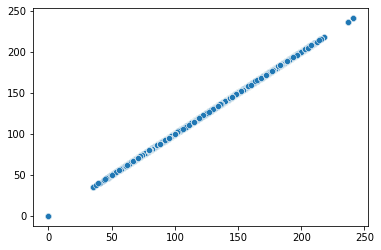

In [ ]:
col1 = 'tempo'
col2 = 'tempo'
sns.scatterplot(x=train[col1].values, y=jtrain[col2].values)

In [ ]:
jtrain['genres_code'] = jtrain['genres'].astype('category').cat.codes
jtrain['name_code'] = jtrain['name_y'].astype('category').cat.codes

jtest['genres_code'] = jtest['genres'].astype('category').cat.codes
jtest['name_code'] = jtest['name_y'].astype('category').cat.codes

In [ ]:
jtrain.loc[:, feats]

,duration_ms,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,release_year,release_month,release_day,followers,art_pop,name_code,genres_code
0,167760.0,0.692,0.792,7,-5.984,0.2450,0.130,0.000000,0.255,0.566,129.883,2019,11.0,15.0,1337237.0,73.0,13405,1461
0,167760.0,0.692,0.792,7,-5.984,0.2450,0.130,0.000000,0.255,0.566,129.883,2019,11.0,15.0,1337237.0,73.0,13405,1470
0,167760.0,0.692,0.792,7,-5.984,0.2450,0.130,0.000000,0.255,0.566,129.883,2019,11.0,15.0,1337237.0,73.0,13405,2868
1,150640.0,0.608,0.447,6,-12.151,0.0663,0.335,0.000035,0.169,0.673,90.777,2007,3.0,21.0,86333.0,49.0,7734,1689
1,150640.0,0.608,0.447,6,-12.151,0.0663,0.335,0.000035,0.169,0.673,90.777,2007,3.0,21.0,86333.0,49.0,7734,1824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27058,276120.0,0.695,0.464,7,-8.277,0.0384,0.631,0.000023,0.453,0.731,145.040,2001,2.0,11.0,251340.0,50.0,11467,2844
27059,102440.0,0.663,0.548,9,-9.953,0.8880,0.284,0.000000,0.757,0.537,99.884,1985,6.0,1.0,23593.0,71.0,11610,1639
27060,256227.0,0.792,0.492,9,-10.642,0.0298,0.366,0.000007,0.179,0.681,133.802,1994,4.0,1.0,91580.0,47.0,8832,2963
27060,256227.0,0.792,0.492,9,-10.642,0.0298,0.366,0.000007,0.179,0.681,133.802,1994,4.0,1.0,91580.0,47.0,8832,2986


In [ ]:
train.head()

,id,name,popularity,duration_ms,artists,id_artists,danceability,energy,key,loudness,...,release_day,art_id,followers,genres,art_pop,gen_id,name_code,artists_code,id_artists_code,gen_id_code
0,269,blun7 a swishland,63,167760.0,['tha Supreme'],['19i93sA0D7yS9dYoVNBqAA'],0.692,0.792,7,-5.984,...,15.0,'19i93sA0D7yS9dYoVNBqAA',-1.0,NaN,-1.0,NaN,18458,12679,1976,-1
1,27504,Que Me Perdone Tu Señora,42,150640.0,['Manoella Torres'],['4JRKcLbpjobmoOVoOXPd6y'],0.608,0.447,6,-12.151,...,21.0,'4JRKcLbpjobmoOVoOXPd6y',-1.0,NaN,-1.0,NaN,13066,7443,7347,-1
2,16082,愛唄~since 2007~,42,242373.0,['whiteeeen'],['6v3VFX2qIWthj4Lr5QIxts'],0.572,0.782,8,-5.275,...,9.0,'6v3VFX2qIWthj4Lr5QIxts',-1.0,NaN,-1.0,NaN,19991,12682,11591,-1
3,14585,Let me be your uncle tonight,12,202989.0,['Tvíhöfði'],['6rmrk3Jk0Ecf8fjioCCZmV'],0.855,0.470,7,-9.252,...,1.0,'6rmrk3Jk0Ecf8fjioCCZmV',-1.0,NaN,-1.0,NaN,9344,11825,11509,-1
4,14740,Never Going Back Again - 2004 Remaster,40,134400.0,['Fleetwood Mac'],['08GQAI4eElDnROBrJRGE0X'],0.654,0.336,6,-12.825,...,4.0,'08GQAI4eElDnROBrJRGE0X',-1.0,NaN,-1.0,NaN,11232,3765,249,-1


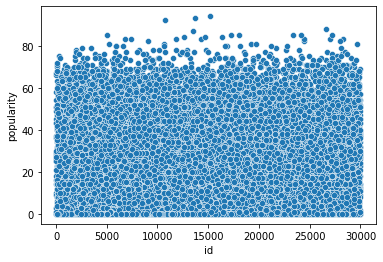

In [ ]:
sns.scatterplot(data=train, x='id', y=target)

In [ ]:
train.columns.values

array(['id', 'name', 'popularity', 'duration_ms', 'artists',
       'id_artists_raw', 'danceability', 'energy', 'key', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'release_year', 'release_month', 'release_day',
       'id_artists', 'followers', 'art_pop', 'genres', 'name_code',
       'artists_code', 'id_artists_code', 'genres_code', 'avg_pop'],
      dtype=object)

In [ ]:
train.head()

,id,name,popularity,duration_ms,artists,id_artists_raw,danceability,energy,key,loudness,...,release_day,id_artists,followers,art_pop,genres,name_code,artists_code,id_artists_code,genres_code,avg_pop
0,269,blun7 a swishland,63,167760.0,['tha Supreme'],['19i93sA0D7yS9dYoVNBqAA'],0.692,0.792,7,-5.984,...,15.0,19i93sA0D7yS9dYoVNBqAA,1337237.0,73.0,italian hip hop,18458,12679,2190,1461,57.0
1,269,blun7 a swishland,63,167760.0,['tha Supreme'],['19i93sA0D7yS9dYoVNBqAA'],0.692,0.792,7,-5.984,...,15.0,19i93sA0D7yS9dYoVNBqAA,1337237.0,73.0,italian pop,18458,12679,2190,1470,57.0
2,269,blun7 a swishland,63,167760.0,['tha Supreme'],['19i93sA0D7yS9dYoVNBqAA'],0.692,0.792,7,-5.984,...,15.0,19i93sA0D7yS9dYoVNBqAA,1337237.0,73.0,trap italiana,18458,12679,2190,2869,57.0
3,27504,Que Me Perdone Tu Señora,42,150640.0,['Manoella Torres'],['4JRKcLbpjobmoOVoOXPd6y'],0.608,0.447,6,-12.151,...,21.0,4JRKcLbpjobmoOVoOXPd6y,86333.0,49.0,latin pop,13066,7443,8293,1689,42.0
4,27504,Que Me Perdone Tu Señora,42,150640.0,['Manoella Torres'],['4JRKcLbpjobmoOVoOXPd6y'],0.608,0.447,6,-12.151,...,21.0,4JRKcLbpjobmoOVoOXPd6y,86333.0,49.0,mexican rock-and-roll,13066,7443,8293,1824,42.0


In [ ]:
feats = ['duration_ms','danceability', 'energy', 'key', 
         'loudness', 'speechiness', 'acousticness', 
         'instrumentalness', 'liveness', 'valence', 
         'tempo', 'release_year', 'release_month', 
         'release_day', 'followers', 'art_pop', 'name_code',
         'genres_code', 'avg_pop']

target = 'popularity'       

In [ ]:
model_data = train.copy()
folds = 5
kf = KFold(folds)
s = pd.Series()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  xtrain = xgb.DMatrix(train_data.loc[:, feats], 
                       train_data[target])
  xtest = xgb.DMatrix(test_data.loc[:, feats], test_data[target])
  p = {
      'objective': 'reg:squarederror'
  }

  model = xgb.train(p, xtrain)
  _s = pd.Series(model.predict(xtest), index=test_data.index)
  s = s.append(_s)

model_data[f"{target}_base"] = s


The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:

mean_squared_error(model_data[target], model_data[f"{target}_base"])**0.5

11.480771778330523

In [ ]:
def tune(trial):
  p = {
      'objective':'reg:squarederror',
       'alpha':trial.suggest_float('alpha',0,2),
       'lambda':trial.suggest_float('lambda',0,2),
       'eta':trial.suggest_float('eta',0,2),
       'max_cat_threshold':trial.suggest_int('max_cat_threshold', 0,10)
  }
  model = xgb.train(p, xtrain)
  _s = pd.Series(model.predict(xtest), index=test_data.index)
  
  loss = mean_squared_error(test_data[target], _s)**0.5
  return loss

In [ ]:
df_params = pd.DataFrame()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  xtrain = xgb.DMatrix(train_data.loc[:, feats], train_data[target])
  xtest = xgb.DMatrix(test_data.loc[:, feats], test_data[target])
  study = optuna.create_study(direction='minimize')
  study.optimize(tune, n_trials=10)
  _df = pd.DataFrame.from_dict([study.best_params])
  df_params = df_params.append(_df)


[I 2022-11-01 07:32:32,705] A new study created in memory with name: no-name-45e933d7-cb56-4f9c-be47-4114ff1c2115
[I 2022-11-01 07:32:33,796] Trial 0 finished with value: 12.847445661830593 and parameters: {'alpha': 0.8660243635714964, 'lambda': 1.6781186231170138, 'eta': 1.1920022828306616, 'max_cat_threshold': 10}. Best is trial 0 with value: 12.847445661830593.
[I 2022-11-01 07:32:34,744] Trial 1 finished with value: 29.494919214730963 and parameters: {'alpha': 1.8291248923758565, 'lambda': 0.7542261898526468, 'eta': 0.017201862474022445, 'max_cat_threshold': 0}. Best is trial 0 with value: 12.847445661830593.
[I 2022-11-01 07:32:35,739] Trial 2 finished with value: 13.983878820722481 and parameters: {'alpha': 0.5551083581162977, 'lambda': 0.3514209647661759, 'eta': 1.61471285094149, 'max_cat_threshold': 5}. Best is trial 0 with value: 12.847445661830593.
[I 2022-11-01 07:32:36,721] Trial 3 finished with value: 11.701905442901133 and parameters: {'alpha': 1.7680194987607256, 'lambda

In [ ]:
_p = df_params.mean().to_dict()

In [ ]:
s = pd.Series()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  xtrain = xgb.DMatrix(train_data.loc[:, feats], train_data[target])
  xtest = xgb.DMatrix(test_data.loc[:, feats], test_data[target])
  p = {
      'objective': 'reg:squarederror'
  }
  
  p = {**p, **_p}

  model = xgb.train(p, xtrain)
  _s = pd.Series(model.predict(xtest), index=test_data.index)
  s = s.append(_s)

model_data[f"{target}_xgb"] = s


The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [ ]:
mean_squared_error(model_data[target], model_data[f"{target}_xgb"])**0.5

11.447070634103293

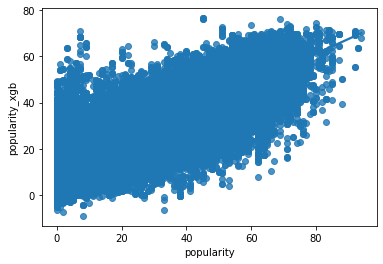

In [ ]:
sns.regplot(data=model_data, x=target, y=f"{target}_xgb")

In [ ]:
p

{'objective': 'reg:squarederror',
 'alpha': 1.010997632526269,
 'lambda': 1.2797757678980775,
 'eta': 0.3870389212288542,
 'max_cat_threshold': 3.8}

In [ ]:
train = pd.read_csv(f"{project_dir}/train.csv")
test = pd.read_csv(f"{project_dir}/test.csv")

artists = pd.read_csv(f"{project_dir}/artists.csv")
artists = (artists
           .merge(artists
                  .loc[:, 'genres']
                  .apply(ast.literal_eval)
                  .explode()
                  .to_frame(), 
                  left_index=True, 
                  right_index=True, 
                  suffixes=('_raw', '')))

artists['genres'] = artists['genres'].fillna('none')
artists = artists.rename(columns={'id':'id_artists', 'popularity':'art_pop'}).loc[:, ['id_artists', 'followers', 'art_pop', 'genres']]

train = train.merge(train.loc[:, 'id_artists'].apply(ast.literal_eval).explode().to_frame(), left_index=True, right_index=True, suffixes=('_raw',''))
test = test.merge(test.loc[:, 'id_artists'].apply(ast.literal_eval).explode().to_frame(), left_index=True, right_index=True, suffixes=('_raw',''))

train = train.merge(artists.rename(columns={'id':'id_artists'}), how='left')
test = test.merge(artists.rename(columns={'id':'id_artists'}), how='left')

train = preprocess(train)
test = preprocess(test)

avg_pop = train.loc[:, ['genres_code', target]].groupby('genres_code', as_index=False).mean().rename(columns={'popularity':'avg_pop'})

train = train.merge(avg_pop, how='left')
test = test.merge(avg_pop, how='left')
test['avg_pop'] = test['avg_pop'].fillna(test['avg_pop'].mean())
train.shape, test.shape

((83260, 28), (35612, 27))

In [ ]:
test['lol'] = train[target].mean()

In [ ]:
p

{'objective': 'reg:squarederror',
 'alpha': 1.010997632526269,
 'lambda': 1.2797757678980775,
 'eta': 0.3870389212288542,
 'max_cat_threshold': 3.8}

In [ ]:
xtrain = xgb.DMatrix(train.loc[:, feats], train[target])
xtest = xgb.DMatrix(test.loc[:, feats], test['lol'])
model = xgb.train(p, xtrain)
test[target] = pd.Series(model.predict(xtest), index=test.index)
test.loc[test[target]<0, target] = 0


count    83260.000000
mean        29.131732
std         19.058333
min          0.000000
25%         13.000000
50%         29.000000
75%         43.000000
max         94.000000
Name: popularity, dtype: float64

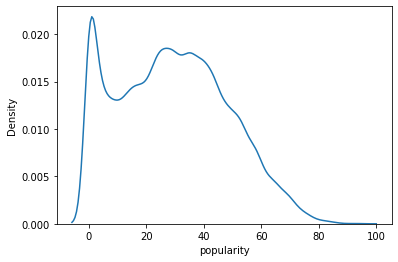

In [ ]:
sns.kdeplot(train[target])
train[target].describe()

count    83260.000000
mean        29.131732
std         19.058333
min          0.000000
25%         13.000000
50%         29.000000
75%         43.000000
max         94.000000
Name: popularity, dtype: float64

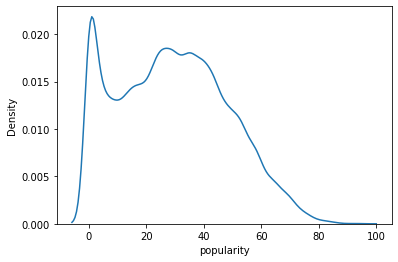

In [ ]:
sns.kdeplot(model_data[target])
model_data[target].describe()

count    83260.000000
mean        28.921892
std         15.126935
min         -9.132811
25%         18.505590
50%         29.414681
75%         39.105818
max         76.567955
Name: popularity_xgb, dtype: float64

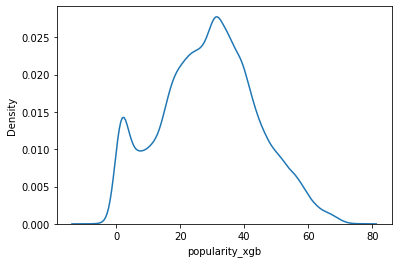

In [ ]:
sns.kdeplot(model_data[f"{target}_xgb"])
model_data[f"{target}_xgb"].describe()

count    35612.000000
mean        29.246883
std         12.707137
min          0.000000
25%         20.608584
50%         29.274216
75%         38.120619
max         71.854668
Name: popularity, dtype: float64

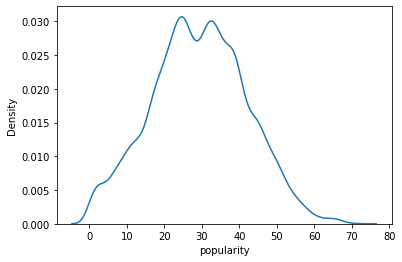

In [ ]:
sns.kdeplot(test[target])
test[target].describe()

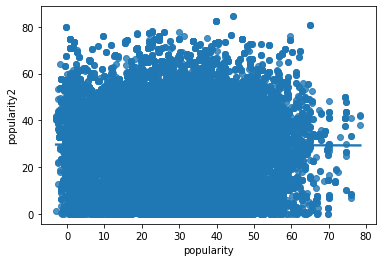

In [ ]:
sns.regplot(data=jtest, x=target, y=f"{target}2")

In [ ]:
_df = test.loc[:, ['id', target]].reset_index().groupby('id', as_index=False).mean()
_df.loc[:, ['id', target]].to_csv('jfdklasf20.csv', index=False)

In [ ]:
test.loc[:, ['id', target]]

,id,popularity
0,21594,4.503881
1,23733,5.523531
2,17440,24.339083
3,26968,25.120605
4,28142,25.433096
...,...,...
8995,10910,26.423664
8996,25962,31.059656
8997,27490,30.860218
8998,22759,20.177319


In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 754 kB/s 


In [ ]:
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
import category_encoders as ce

In [ ]:
xb = make_pipeline(ce.TargetEncoder(), XGBRegressor())


Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


In [ ]:
xb.fit(train.loc[:, feats],train.loc[:, target])

[06:26:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(steps=[('targetencoder', TargetEncoder(cols=[])),
                ('xgbregressor', XGBRegressor())])

In [ ]:
test[target] = pd.Series(xb.predict(test.loc[:, feats]), index=test.index)

In [ ]:
_df = test.loc[:, ['id', target]].reset_index().groupby('id', as_index=False).mean()
_df.loc[:, ['id', target]].to_csv('jfdklasf16.csv', index=False)

# to beat: 14.284126890127123